# Overview

In this tutorial we will introduce key concepts related to creating simple convolutional neural networks.

**Convolutional Neural Networks**

* convolutional operations
* softmax cross-entroy loss
* model training
* evaluation
* visualization

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [ ]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 81 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 13.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [ ]:
import numpy as np, pandas as pd
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of the CIFAR-10 dataset comprising 10 different everyday objects (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/cifar`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [ ]:
# --- Download dataset
datasets.download(name='cifar')

[ 2021-12-29 04:40:57 ] [====================] 100.000% : Extracting archive (0000004 / 0000004) 

{'code': '/data/raw/cifar', 'data': '/data/raw/cifar'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality. As needed, pass any custom configurations (e.g. batch size, normalization parameters, etc) into the optional `configs` dictionary argument.

In [ ]:
# --- Prepare generators
configs = {'batch': {'size': 36}}
gen_train, gen_valid, client = datasets.prepare(name='cifar', configs=configs)

[ 2021-12-29 04:40:59 ] [====================] 100.000% : Iterating | 000001    

The created generators yield a total of `n` training samples based on the specified batch size. As before, each iteration yields two variables, `xs` and `ys`, each representing a dictionary of model input(s) and output(s). In the current example, there is just a single input and output. Let us examine the generator data:

In [ ]:
# --- Yield one example
xs, ys = next(gen_train)

# --- Print dict keys
print('xs keys: {}'.format(xs.keys()))
print('ys keys: {}'.format(ys.keys()))

xs keys: dict_keys(['dat'])
ys keys: dict_keys(['class'])


In [ ]:
# --- Print data shape
print('xs shape: {}'.format(xs['dat'].shape))
print('ys shape: {}'.format(ys['class'].shape))

xs shape: (36, 32, 32, 3)
ys shape: (36, 1)


Use the following lines of code to visualize using the `imshow(...)` method:

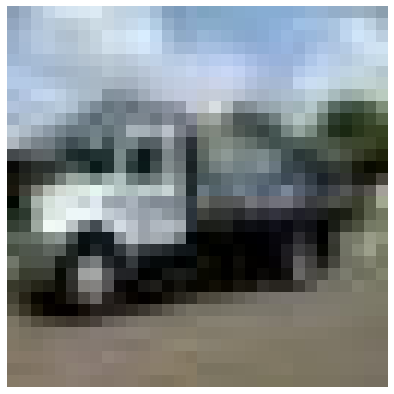

In [ ]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

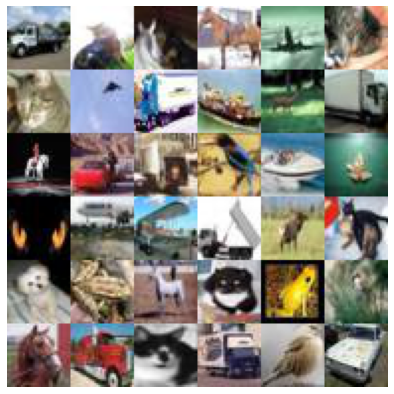

In [ ]:
# --- Show "montage" of all images
imshow(xs['dat'])

As expected, the 36-element `ys['class']` vector corresponds to ground-truth:

In [ ]:
# --- Print ys['digit']
print(ys['class'].reshape(6,6))

[[9 3 7 7 0 3]
 [3 0 9 8 4 9]
 [7 1 9 2 8 6]
 [3 0 0 9 4 3]
 [5 6 7 3 6 2]
 [7 9 3 9 2 1]]


### Model inputs

For every input in `xs`, a corresponding `Input(...)` variable can be created and returned in a `inputs` dictionary for ease of model development:

In [ ]:
# --- Create model inputs
inputs = client.get_inputs(Input)

print(inputs.keys())
print(inputs['dat'].shape)

dict_keys(['dat'])
(None, 32, 32, 3)


In this example, the equivalent Python code to generate `inputs` would be:

```python
inputs = {}
inputs['dat'] = Input(shape=(32, 32, 3))
```

# Convolutional Operations

In this tutorial, a CNN will be created using 2D convolutional operations. Recall that convolutional operations are defined by the following minimum specifications:

* filter / channel depth
* kernel size
* strides
* padding

To instatiate a convolutional layer in Keras:

In [ ]:
# --- Define regular convolution
l1 = layers.Conv2D(
    filters=16, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding='same')(inputs['dat'])

# --- Define strided convolution
l1 = layers.Conv2D(
    filters=16, 
    kernel_size=(3, 3), 
    strides=(2, 2), 
    padding='same')(inputs['dat'])

To reuse identical function arguments, consider maintaining a `kwargs` dictionary and pass using the `**` symbol:

In [ ]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (3, 3),
    'padding': 'same'}

# ---- Define stack of convolutions
l1 = layers.Conv2D(filters=16, strides=(1, 1), **kwargs)(inputs['dat'])
l2 = layers.Conv2D(filters=32, strides=(1, 1), **kwargs)(l1)

In [ ]:
inputs['dat']

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'dat')>

In [ ]:
l1

<KerasTensor: shape=(None, 32, 32, 16) dtype=float32 (created by layer 'conv2d_2')>

In [ ]:
l2

<KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'conv2d_3')>

## Blocks

In addition to the requisite convolutional operationss and activation functions, batch normalization is almost universally used in modern CNN architectures. Thus at minimum, a common baseline *block* pattern of operations can be defined as:

* convolutional operation
* batch normalization
* activation function (e.g. ReLU)

Let us define a block:

In [ ]:
# --- Define block
c1 = layers.Conv2D(filters=16, **kwargs)(inputs['dat'])
n1 = layers.BatchNormalization()(c1)
r1 = layers.ReLU()(n1)

During the course of buildling CNNs, we will be writing **many** blocks over time. Thus for brevity, let us use lambda functions to define modular, reusable components:

In [ ]:
# --- Define lambda functions for shorthand
conv = lambda x, filters, strides : layers.Conv2D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

Great! Now let us rewrite a block using lambda shorthand:

In [ ]:
# --- Define block (shorthand of code block [17])
b1 = relu(norm(conv(inputs['dat'], 16, (1, 1))))

In practice, the two most common **block patterns** will be regular convolutional block and a strided convolutional block (for subsampling). Let us then create two more high-level lambda functions for this:

In [ ]:
# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(2, 2))))

Now let us see how easy it is to create series of alternating stride-1 and stride-2 blocks:

In [ ]:
# --- Define series of blocks
l1 = conv1(16, inputs['dat'])
l2 = conv1(24, conv2(24, l1))
l3 = conv1(32, conv2(32, l2))
l4 = conv1(48, conv2(48, l3))

In [ ]:
inputs['dat']

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'dat')>

In [ ]:
l1

<KerasTensor: shape=(None, 32, 32, 16) dtype=float32 (created by layer 're_lu_2')>

In [ ]:
l2

<KerasTensor: shape=(None, 16, 16, 24) dtype=float32 (created by layer 're_lu_4')>

In [ ]:
l3

<KerasTensor: shape=(None, 8, 8, 32) dtype=float32 (created by layer 're_lu_6')>

In [ ]:
l4

<KerasTensor: shape=(None, 4, 4, 48) dtype=float32 (created by layer 're_lu_8')>

# Fully Connected Layers

After a series of convolutional block operations, recall that the CNN must transition to MLP type operations (e.g. matrix multiplications). To convert 3D (or 4D) feature maps into vectors, consider one of the following approaches:

* serial convolutions (with stride > 1 or VALID type padding)
* global pool operations (mean or max)
* reshape / flatten operation

The following line of code implements the reshape / flatten operation:

In [ ]:
f0 = layers.Flatten()(l4)

In [ ]:
f0

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'flatten')>

The other options are described in further detail in the tutorial exercises.

### MLP

Now that the intermediate layer is defined as a vector, a number of standard MLP type operations may be performed, including creation of an arbitrary (optional) number of hidden layers. As before, the final layer should yield a vector of logit scores **without** any activation function applied.

In [ ]:
# --- Add hidden layers if needed
# .... (optional) ...

# --- Final logit scores
logits = {}
logits['class'] = layers.Dense(10, name='class')(f0)

# Model

Putting everything together, use the following cell to create and compile the convolutional neural network:

In [ ]:
# --- Create model
model = Model(inputs=inputs, outputs=logits)

# --- Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-4), 
    loss={'class': losses.SparseCategoricalCrossentropy(from_logits=True)}, 
    metrics={'class': 'sparse_categorical_accuracy'})

# Model Training

Once the model has been compiled and the data prepared (via a generator), training can be invoked using the `model.fit(...)` method. Ensure that both the training and validation data generators are used. In this particular example, we are defining arbitrary epochs of 250 steps each. Training will proceed for 12 epochs in total. Validation statistics will be assess every fourth epoch. As needed, tune these arugments as need.

In [ ]:
model.fit(
    x=gen_train, 
    steps_per_epoch=250, 
    epochs=12,
    validation_data=gen_valid,
    validation_steps=250,
    validation_freq=4)

Epoch 1/12
250/250 [==============================] - 42s 157ms/step - loss: 2.0576 - sparse_categorical_accuracy: 0.2672
Epoch 2/12
250/250 [==============================] - 26s 102ms/step - loss: 1.6774 - sparse_categorical_accuracy: 0.3959
Epoch 3/12
250/250 [==============================] - 26s 102ms/step - loss: 1.5675 - sparse_categorical_accuracy: 0.4363
Epoch 4/12
250/250 [==============================] - 37s 149ms/step - loss: 1.5082 - sparse_categorical_accuracy: 0.4512 - val_loss: 1.4749 - val_sparse_categorical_accuracy: 0.4662
Epoch 5/12
250/250 [==============================] - 26s 105ms/step - loss: 1.4380 - sparse_categorical_accuracy: 0.4787
Epoch 6/12
250/250 [==============================] - 33s 133ms/step - loss: 1.3561 - sparse_categorical_accuracy: 0.5124
Epoch 7/12
250/250 [==============================] - 40s 160ms/step - loss: 1.3095 - sparse_categorical_accuracy: 0.5348
Epoch 8/12
250/250 [==============================] - 36s 145ms/step - loss: 1.2765 -

### Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* use `np.argmax(...)` to obtain prediction
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, we will create new **test mode** data generators, which will simply load each example individually once for testing. 

In [ ]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True)

Use the following lines of code to yield all examples from the valid generator:

In [ ]:
# --- Aggregate all examples
xs = []
ys = []

for x, y in test_valid:
    xs.append(x['dat'])
    ys.append(y['class'])

xs = np.concatenate(xs)
ys = np.concatenate(ys)

[ 2021-12-29 04:47:53 ] [====================] 100.000% : Iterating | 012000    

Use the following lines of code to run prediction through the **valid** cohort generator:

In [ ]:
xs.shape

(12000, 32, 32, 3)

In [ ]:
# --- Predict
logits = model.predict(xs)

if type(logits) is dict:
    logits = logits['class']

# --- Argmax
pred = np.argmax(logits, axis=1)

Prepare results in Pandas DataFrame for ease of analysis and sharing:

In [ ]:
df = pd.DataFrame(index=np.arange(pred.size))

# --- Define columns
df['true'] = ys[:, 0]
df['pred'] = pred
df['corr'] = df['true'] == df['pred']

# --- Print accuracy
print(df['corr'].mean())

0.56625


## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `model.save()` and `models.load_model()` methods. 

In [ ]:
# --- Serialize a model
model.save('./cnn.hdf5')

In [ ]:
# --- Load a serialized model
del model
model = models.load_model('./cnn.hdf5', compile=False)

# Exercises

Up until this point, this tutorial has presented a baseline of minimum requirements needed to successful train a CNN. The following exercises will assist in further optimization and customization of network architecture as well as hyperparameter considerations. Upon completion, apply any combination of techniques explored in this tutorial to finish the assignment: to train a CNN on the CIFAR-10 dataset.

### Exercise 1

In addition a matrix flatten operation, conversion from 3D (or 4D) feature maps into vectors may be accomplished via:

* serial convolutions (with stride > 1 or VALID type padding)
* global pool operations (mean or max)

Use the following cell to implement this two alternative methods:

In [ ]:
inputs['dat']

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'dat')>

In [ ]:
# --- Define series of blocks
l1 = conv1(16, inputs['dat'])
l2 = conv1(24, conv2(24, l1))
l3 = conv1(32, conv2(32, l2))
l4 = conv1(48, conv2(48, l3))

# --- Convert l4 to vector via serial convolution(s)
op = layers.Conv2D(
    filters=48, 
    kernel_size=(3,3), 
    strides=(1,1), 
    padding='same')(l3)



#vector = ?

# --- Contert l4 to vector via global pool operations
op = layers.MaxPooling2D()(l4)
#vector = ?

In [ ]:
l1.shape

TensorShape([None, 32, 32, 16])

In [ ]:
l2.shape

TensorShape([None, 16, 16, 24])

In [ ]:
l3.shape

TensorShape([None, 8, 8, 32])

In [ ]:
l4.shape

TensorShape([None, 4, 4, 48])

In [ ]:
op.shape

TensorShape([None, 2, 2, 48])

In [ ]:
ys.shape

(12000, 1)

#### Hints

To implement via serial convolution(s), consider first the size of the last feature map layer. Why is this size important? Accordiningly, what size must the convolutional filter be to accomplish the goal of generating a `1 x 1 x C` feature map? In addition to changes in convolutional `kernel_size`, how to modifications to `stride` and `padding` effect the output layer size?

Use the following cell to experiment:

In [ ]:
# --- Check l4 size
l4.shape

# --- Alter convolutional kernel size

# --- Alter convolutional stride

# --- Alter convolutional padding

TensorShape([None, 4, 4, 48])

To implement via global pooling operations, consider referencing the Keras API here: http://faroit.com/keras-docs/1.0.8/layers/pooling/. 

### Exercise 2

To limit overfitting, consider use of an L2 regularizer. Recall that this technique adds an extra term to the loss function such that in addition to optimizing for classification accuracy, the model also will attempt to minimize overall L2 distance of all network parameters. 

In the Tensorflow 2.0 / Keras API, a `kernel_reguarlizer` can be specified in the definition of any layer operation: 

In [ ]:
from tensorflow.keras import regularizers

# --- Use regularizer
op = layers.Conv2D(
    filters=16, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding='same',
    kernel_regularizer=regularizers.l2(0.01))

l1 = relu(norm(op(inputs['dat'])))

The *lambda* parameter passed into the `regularizers.l2(...)` call is a constant value by which to scale this component of the loss; for more L2 regularization, use higher values. A *lambda* value of 0 is equivalent to no regularizer use at all.

#### Hints

What other types of regularizers are present in the `regularizers.*` module? Can L1, L2 and/or both L1/L2 be used? What would be the relative benefit of some of these alternatives?

### Exercise 3

To limit overfitting, consider use of Dropout. The `rate` argument passed during initialization determines the **fraction of input units to drop**. Thus a rate of 0.25 will retain 75% of activation values.

In [ ]:
# --- Define dropout
drop = layers.Dropout(rate=0.25)

When using the ReLU activation function, dropout can be applied either before or after the activation function (otherwise it is most common to apply dropout after the activation function). Also recall that dropout is most efficient in the MLP portions of your network. Finally just as the final matrix multiplication should not be defined with any activation function, ensure the **no dropout** is used in the final layer either.

In [ ]:
# --- Define series of blocks
l1 = conv1(16, inputs['dat'])
l2 = conv1(24, conv2(24, l1))
l3 = conv1(32, conv2(32, l2))
l4 = conv1(48, conv2(48, l3))

# --- Flatten
f0 = layers.Flatten()(l4)

# --- Use dropout
hidden_size = 64
f1 = drop(layers.Dense(hidden_size, activation='relu')(f0))